# Train your custom YOLOv5 Visual Inspection model
*Based on and inspired by the  [Yolov5 Tutorials](https://github.com/ultralytics/yolov5/wiki/) by  [Ultralytics](https://ultralytics.com)*

In this notebook we are going to train a custom Yolov5 model for detecting anomalies in images. The data set for this demonstrator is based on the Metal Nut Data Set from mvtec.com

**Metal Nut Data Set**
- Credits to https://www.mvtec.com/company/research/datasets
- See also: https://www.mvtec.com/company/research/datasets/mvtec-ad

**ATTRIBUTION**

Paul Bergmann, Michael Fauser, David Sattlegger, Carsten Steger. MVTec AD - A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection; in: IEEE Conference on Computer Vision and Pattern Recognition (CVPR), June 2019

**LICENSE**

The data is released under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (CC BY-NC-SA 4.0). For using the data in a way that falls under the commercial use clause of the license, please contact us via the form below.

# Setup

Clone GitHub [repository](https://github.com/ultralytics/yolov5), install [dependencies](https://github.com/ultralytics/yolov5/blob/master/requirements.txt) and check PyTorch and GPU.

In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 15305, done.
remote: Total 15305 (delta 0), reused 0 (delta 0), pack-reused 15305
Receiving objects: 100% (15305/15305), 14.19 MiB | 26.80 MiB/s, done.
Resolving deltas: 100% (10497/10497), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.3.0 requires setuptools<=64.0.2, but you have setuptools 67.6.0 which is incompatible.


In [3]:
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 25.5/78.2 GB disk)


# Test the setup 

`detect.py` runs YOLOv5 inference on a variety of sources, downloading models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases), and saving results to `runs/detect`. Example inference sources are:

```shell
python detect.py --source 0  # webcam
                          img.jpg  # image 
                          vid.mp4  # video
                          screen  # screenshot
                          path/  # directory
                         'path/*.jpg'  # glob
                         'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                         'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

100% 14.1M/14.1M [00:00<00:00, 79.3MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 20.7ms
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, 19.9ms
Speed: 0.5ms pre-process, 20.3ms inference, 19.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


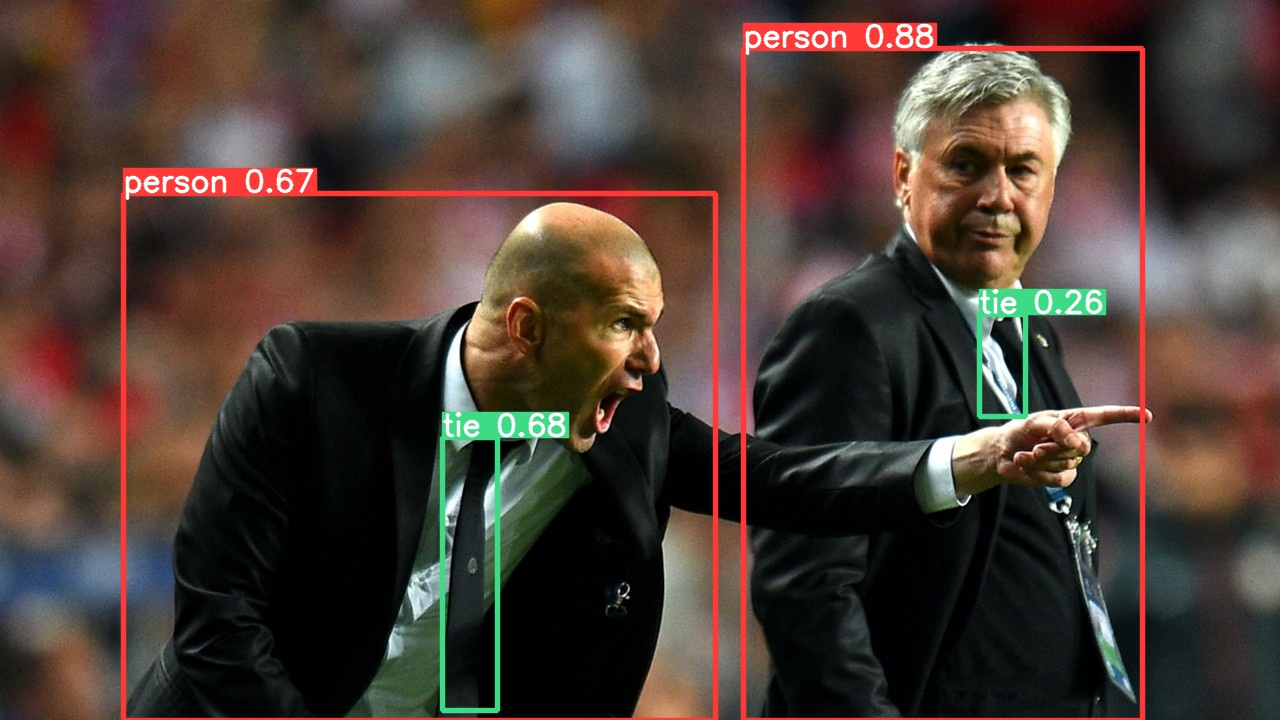

In [4]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images
display.Image(filename='runs/detect/exp/zidane.jpg', width=600)

# Download and prepare the training data


In [5]:
# Download the labled metal nut images
!curl -O https://raw.githubusercontent.com/stefan-bergstein/manuela-visual-inspection/main/ml/darknet/data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43.7M  100 43.7M    0     0  26.4M      0  0:00:01  0:00:01 --:--:-- 26.4M


In [6]:
# Unzip the images and annoations
!mkdir data/manuela
!unzip -q data.zip -d data/manuela && rm data.zip
!ls -l data/manuela/data

total 32
-rw-rw-r-- 1 root root   108 Jan 24  2021 metal-data.data
drwxrwxr-x 2 root root  4096 Jan 24  2021 metal_yolo
-rw-rw-r-- 1 root root   534 Apr  9  2021 test.txt
-rw-rw-r-- 1 root root  2225 Apr  9  2021 train.txt
-rw-rw-r-- 1 root root 12297 Jan 24  2021 yolov4-custom-metal.cfg


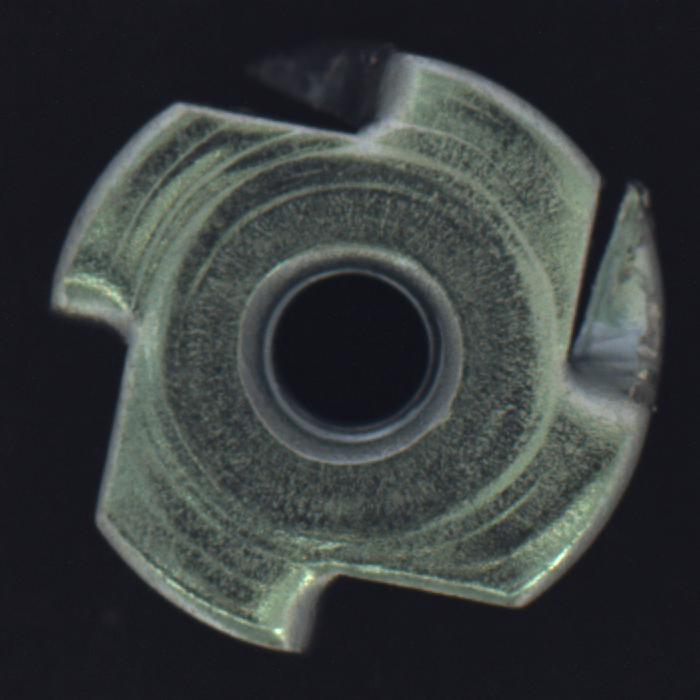

In [7]:
# View image 
display.Image(filename='data/manuela/data/metal_yolo/bent-000.png', width=600)

In [8]:
# Show annotation
!cat data/manuela/data/metal_yolo/bent-000.txt

1 0.8842857142857142 0.425 0.13714285714285715 0.33285714285714285
1 0.46 0.11857142857142858 0.22 0.13142857142857142


In [10]:
# Create required file and directory structure
!curl -LO https://raw.githubusercontent.com/stefan-bergstein/manuela-visual-inspection/main/ml/scripts/prep-data.sh
!chmod +x ./prep-data.sh && ./prep-data.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   766  100   766    0     0  20157      0 --:--:-- --:--:-- --:--:-- 20157
Hello, prep files for Yolov5 training...
data/metal_yolo/bent-013.png
data/metal_yolo/color-001.png
data/metal_yolo/good-009.png
data/metal_yolo/scratch-006.png
data/metal_yolo/scratch-012.png
data/metal_yolo/scratch-020.png
data/metal_yolo/good-020.png
data/metal_yolo/color-008.png
data/metal_yolo/scratch-011.png
data/metal_yolo/good-010.png
data/metal_yolo/bent-005.png
data/metal_yolo/bent-021.png
data/metal_yolo/scratch-000.png
data/metal_yolo/scratch-017.png
data/metal_yolo/bent-022.png
data/metal_yolo/color-021.png
data/metal_yolo/color-020.png
data/metal_yolo/bent-016.png
data/metal_yolo/scratch-022.png
data/metal_yolo/bent-007.png
data/metal_yolo/good-014.png
data/metal_yolo/scratch-016.png
data/metal_yolo/good-019.png
data/metal_yolo/color-009.p

In [11]:
# Train YOLOv5s on Metal Nuts for 3 epochs
#%load_ext tensorboard
#%tensorboard --logdir runs/train
!python train.py --img 700 --batch 16 --epochs 300 --data data/metal-nut-data/data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=data/metal-nut-data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=700, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_

In [12]:
# Check

# Test model

In [13]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 700 --conf 0.25 --source data/manuela/data/metal_yolo/bent-000.png
#display.Image(filename='runs/detect/exp/zidane.jpg', width=600)

detect: weights=['runs/train/exp/weights/best.pt'], source=data/manuela/data/metal_yolo/bent-000.png, data=data/coco128.yaml, imgsz=[700, 700], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ --img-size [700, 700] must be multiple of max stride 32, updating to [704, 704]
image 1/1 /content/yolov5/data/manuela/data/metal_yolo/bent-000.png: 704x704 1 bent, 14.1ms
Speed: 0.7ms pre-process, 14.1ms inference, 1.5ms NMS per image at shape (1, 3, 704, 704)
Results saved to runs/detect/exp2


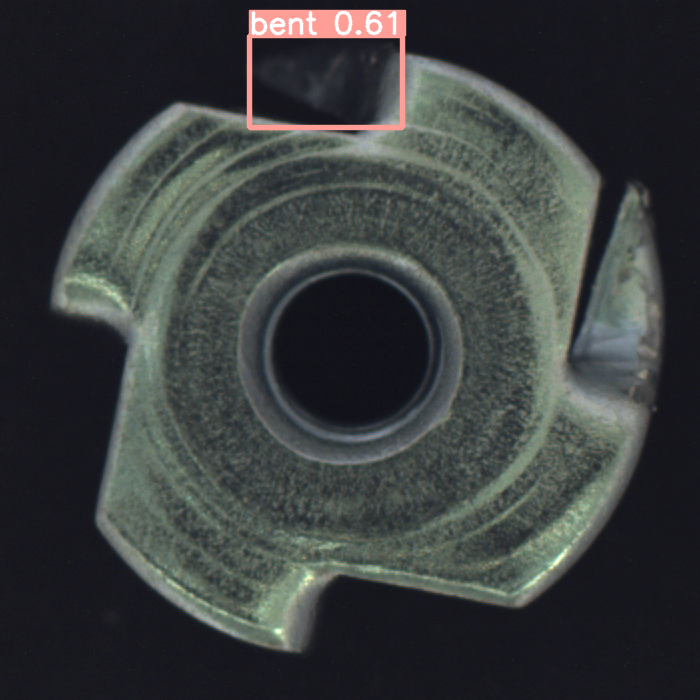

In [14]:
display.Image(filename='runs/detect/exp2/bent-000.png', width=600)

# Export YoloV5 model to ONNX format
Source: [01-yolov5_to_onnx.ipynb](https://github.com/rh-aiservices-bu/yolov5-model-serving/blob/main/01-yolov5_to_onnx.ipynb)
* Eventually modify the image size if you selected  a model with the "6" suffix, as image size is 1280 (and not 640)
* Stay at opset 16 for the moment for OpenVino model server compatibility


In [15]:
!python export.py --weights runs/train/exp/weights/best.pt --include onnx --imgsz 700 --opset 16

export: data=data/coco128.yaml, weights=['runs/train/exp/weights/best.pt'], imgsz=[700], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=16, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ --img-size 700 must be multiple of max stride 32, updating to 704
WARNING ⚠️ --img-size 700 must be multiple of max stride 32, updating to 704

PyTorch: starting from runs/train/exp/weights/best.pt with output shape (1, 30492, 7) (13.8 MB)
requirements: YOLOv5 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the 

# Save work into tar file for download

In [17]:
!tar -czvf manu-vi-yolo5-run.tar.gz runs/

runs/
runs/detect/
runs/detect/exp2/
runs/detect/exp2/bent-000.png
runs/detect/exp/
runs/detect/exp/bus.jpg
runs/detect/exp/zidane.jpg
runs/train/
runs/train/exp/
runs/train/exp/F1_curve.png
runs/train/exp/events.out.tfevents.1679222847.ef8b8afbb757.2089.0
runs/train/exp/val_batch0_pred.jpg
runs/train/exp/R_curve.png
runs/train/exp/labels_correlogram.jpg
runs/train/exp/opt.yaml
runs/train/exp/train_batch1.jpg
runs/train/exp/val_batch0_labels.jpg
runs/train/exp/results.png
runs/train/exp/train_batch2.jpg
runs/train/exp/confusion_matrix.png
runs/train/exp/P_curve.png
runs/train/exp/weights/
runs/train/exp/weights/last.pt
runs/train/exp/weights/best.onnx
runs/train/exp/weights/best.pt
runs/train/exp/PR_curve.png
runs/train/exp/results.csv
runs/train/exp/labels.jpg
runs/train/exp/train_batch0.jpg
runs/train/exp/hyp.yaml
